<a href="https://colab.research.google.com/github/Chiaradisanto/Segmentation/blob/main/unet-accuracy-amiloidosi-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
import os
batch_size=16

In [2]:
seed=24
batch_size=16
n_classes=1
from tensorflow.keras.preprocessing.image import ImageDataGenerator




#Define the generator.
#We are not doing any rotation or zoom to make sure mask values are not interpolated.
#It is important to keep pixel values in mask as 0, 1, 2, 3, .....
def trainGenerator(train_img_path, train_mask_path):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect',shear_range=0.5, 
                      rotation_range=50,
                      zoom_range=0.2,
                      width_shift_range=0.2, height_shift_range=0.2,
            
                      rescale=1/255.)
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
   
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        color_mode = 'grayscale',
        target_size=(512,512),
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None ,
        color_mode = 'grayscale',
        target_size=(512,512),
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    return train_generator

In [4]:
train_img_path = "/gdrive/MyDrive/TESI/output/train/train_images"
train_mask_path = "/gdrive/MyDrive/TESI/output/train/train_masks"
train_img_gen = trainGenerator(train_img_path, train_mask_path)

val_img_path = "/gdrive/MyDrive/TESI/output/train/val_images"
val_mask_path = "/gdrive/MyDrive/TESI/output/train/val_masks"
val_img_gen = trainGenerator(val_img_path, val_mask_path)

Found 2960 images belonging to 1 classes.
Found 2960 images belonging to 1 classes.
Found 320 images belonging to 1 classes.
Found 320 images belonging to 1 classes.


In [5]:
x, y = train_img_gen.__next__()

In [6]:
print(x.shape)
print(y.shape)

(16, 512, 512, 1)
(16, 512, 512, 1)


In [7]:
#Define the model metrcis and load model. 

num_train_imgs = len(os.listdir('/gdrive/MyDrive/TESI/output/train/train_images/images'))
num_val_images = len(os.listdir('/gdrive/MyDrive/TESI/output/train/val_images/images'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)

(512, 512, 1)


In [8]:
import tensorflow as tf


In [9]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

In [10]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

In [11]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('UNETaccuracyamiloidosi.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=1, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

In [36]:
from keras import backend as K

from tensorflow.keras.optimizers import Adam

In [38]:
model.compile( optimizer=Adam(1e-4), loss='binary_crossentropy', metrics='accuracy')

In [39]:
history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=30,
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch,
          callbacks=callbacks)

Epoch 1/30
185/185 [==============================] - 244s 1s/step - loss: 0.1703 - accuracy: 0.9675 - val_loss: 0.0825 - val_accuracy: 0.9771
Epoch 2/30
185/185 [==============================] - 239s 1s/step - loss: 0.1146 - accuracy: 0.9682 - val_loss: 0.0790 - val_accuracy: 0.9782
Epoch 3/30
185/185 [==============================] - 235s 1s/step - loss: 0.1050 - accuracy: 0.9680 - val_loss: 0.0850 - val_accuracy: 0.9788


In [40]:
#Save the model for future use
model.save('/gdrive/MyDrive/TESI/UNET-AMILOIDOSI-accuracy.hdf5')

In [41]:
#Load previously saved model
from keras.models import load_model
model = load_model("/gdrive/MyDrive/TESI/UNET-AMILOIDOSI-accuracy.hdf5", compile=False)

In [42]:
test_image_batch, test_mask_batch = val_img_gen.__next__()

In [43]:
y_pred=model.predict(test_image_batch)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_argmax = np.argmax(test_mask_batch, axis=3)

In [44]:
import numpy as np

In [45]:
from matplotlib import pyplot as plt

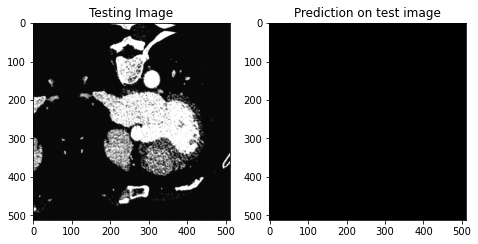

In [49]:

import random
test_img_number = random.randint(0, len(test_image_batch)-1)
test_img = test_image_batch[test_img_number]
ground_truth=test_mask_batch[test_img_number]
ground_truth = np.argmax(ground_truth, axis=2)
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)

plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='gray')
plt.show()